# Determining the value of the car

A used car sales service is developing an application to attract new customers. The application allows users to quickly determine the market value of their car. We have historical data at our disposal, including technical specifications, configurations, and prices of cars. Our task is to build a model to estimate the car's value.

The client has the following priorities:

Prediction accuracy
Prediction speed
Training time.

## Data preparation

### Upload libraries

In [1]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -U lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install -U phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42

### Data uploading and preprocessing

In [6]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
df.duplicated().sum()

4

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

(None,
 DateCrawled              0
 Price                    0
 VehicleType          37490
 RegistrationYear         0
 Gearbox              19833
 Power                    0
 Model                19705
 Kilometer                0
 RegistrationMonth        0
 FuelType             32895
 Brand                    0
 Repaired             71154
 DateCreated              0
 NumberOfPictures         0
 PostalCode               0
 LastSeen                 0
 dtype: int64)

In [11]:
df.Repaired.value_counts(normalize=True, dropna=False)

no     0.697467
NaN    0.200793
yes    0.101740
Name: Repaired, dtype: float64

As you can see, there are a lot of missing values in the dataset, in some columns, such as Repaired, this value exceeds 20%. The best solution would be to get rid of the omissions altogether and write to the application developers to block the possibility of publishing an ad without fully filled in fields. But while the developers will correct the requirements for making an announcement, we will work with what is there.
Since the omissions are present in the columns of the object type, we will replace them with a stub 'tbd' (to be determined).

In [12]:
df = df.fillna('tbd')

In [13]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Removing anamole values:

1.Zero month

2.t.k. the year of the invention of the car is 1886, you can safely remove everything that was before 1900 and after 2023

3.To date, the Dagger GT of TranStar Racing LLC with a capacity of 2028 hp has been named the most powerful passenger car in the world. Accordingly, everything above will be considered anomalies. Cars with zero power capacity are possible without an engine and are sold for spare parts.

4.The price below 100 euros seems suspiciously low, we will remove everything below this mark

In [14]:
df = df[(df['RegistrationMonth'] != 0)]
df = df[df['RegistrationYear'].between(1910, 2019)]
df = df[df['Power'] < 2028]
df = df[df['Price'] > 100]

In [15]:
df['DateCreated'] = df['DateCreated'].astype('datetime64')
df['LastSeen'] = df['LastSeen'].astype('datetime64')

In [16]:
df['ad_lifetime'] = (df['LastSeen'] - df['DateCreated']).dt.days

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308732 entries, 1 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        308732 non-null  object        
 1   Price              308732 non-null  int64         
 2   VehicleType        308732 non-null  object        
 3   RegistrationYear   308732 non-null  int64         
 4   Gearbox            308732 non-null  object        
 5   Power              308732 non-null  int64         
 6   Model              308732 non-null  object        
 7   Kilometer          308732 non-null  int64         
 8   RegistrationMonth  308732 non-null  int64         
 9   FuelType           308732 non-null  object        
 10  Brand              308732 non-null  object        
 11  Repaired           308732 non-null  object        
 12  DateCreated        308732 non-null  datetime64[ns]
 13  NumberOfPictures   308732 non-null  int64   

Let's remove useless features such as 'DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures' and check the correlation between the remaining features with the help of $\phi_K$

In [18]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode', 'ad_lifetime']


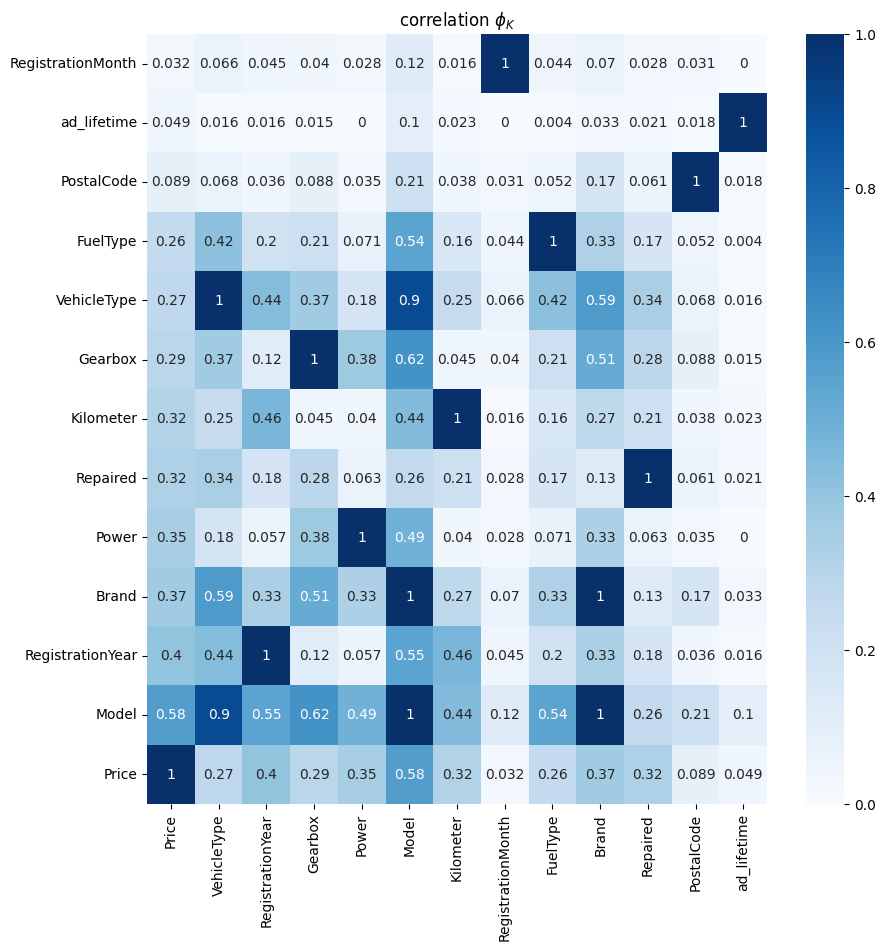

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.phik_matrix().sort_values(by='Price'), cmap='Blues', annot=True)
plt.title('correlation $\phi_K$');

There is no strong multicollinearity between the signs. Let's move on

### Splitting into training and test samples

Let's split dataset into train and test samples with test size of 20 percentage.

In [20]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

We need to create lists with columns names of different data types to add them into column transformer.

In [22]:
cat_features = X.select_dtypes(include='object').columns.to_list()
num_features = X.select_dtypes(exclude='object').columns.to_list()

In [23]:
display(X_train[cat_features].head()), display(X_train[num_features].head())

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
73842,sedan,auto,other,petrol,opel,no
83266,bus,manual,sharan,petrol,volkswagen,no
342028,small,manual,corsa,petrol,opel,no
52198,small,manual,fiesta,lpg,ford,no
160299,sedan,auto,other,petrol,mercedes_benz,no


,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,ad_lifetime
73842,1975,130,90000,3,15732,19
83266,1997,175,150000,4,27386,12
342028,2005,58,125000,5,27442,6
52198,2013,60,50000,7,40885,30
160299,1982,136,150000,10,74564,7


(None, None)

In [24]:
col_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

## Building and training

Let's build three models Ridge, LGBMRegressor and CatBoostRegressor using a pipeline and their own categorical feature encoders.

### Ridge

In [25]:
rd = Ridge(random_state=RANDOM_STATE)
param_grid_rd = {'ridge__alpha': range(1, 10)}

pipeline_rd = make_pipeline(col_transformer, rd)
grid_search_rd = GridSearchCV(estimator=pipeline_rd, 
                                    param_grid=param_grid_rd,
                                    scoring='neg_root_mean_squared_error',
                                    cv = 5,
                                    n_jobs = -1)
grid_search_rd.fit(X_train, y_train)
best_param_rd = pd.DataFrame(grid_search_rd.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_rd = best_param_rd[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_rd

,mean_fit_time,mean_score_time,params,mean_test_score
8,0.629016,0.13155,{'ridge__alpha': 9},-3176.161765


### LGBMRegressor

In [26]:
lgbr = LGBMRegressor(random_state=RANDOM_STATE)
param_grid_lgbr = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 5, 7],
                   'learning_rate': [0.1, 0.3]}

X_train[cat_features] = X_train[cat_features].astype('category')

grid_search_lgbr = GridSearchCV(estimator = lgbr, 
                              param_grid = param_grid_lgbr, 
                              scoring='neg_root_mean_squared_error', 
                              cv = 5, 
                              n_jobs = -1)
grid_search_lgbr.fit(X_train, y_train)
best_param_lgbr = pd.DataFrame(grid_search_lgbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_lgbr = best_param_lgbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_lgbr

,mean_fit_time,mean_score_time,params,mean_test_score
17,6.863362,1.459509,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",-1577.220215


### CatBoostRegressor

In [27]:
ctbr = CatBoostRegressor(cat_features=cat_features, random_state=RANDOM_STATE, verbose=False)
param_grid_ctbr = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 5, 7],
                   'learning_rate': [0.1, 0.3]}
grid_search_ctbr = GridSearchCV(estimator = ctbr, 
                              param_grid = param_grid_ctbr, 
                              scoring='neg_root_mean_squared_error', 
                              cv = 5, 
                              n_jobs = -1)
grid_search_ctbr.fit(X_train, y_train)
best_param_ctbr = pd.DataFrame(grid_search_ctbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_ctbr = best_param_ctbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_ctbr

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,mean_fit_time,mean_score_time,params,mean_test_score
17,169.032273,0.358586,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",-1593.421554


## Model analysis

In [28]:
result = pd.concat([best_param_rd, best_param_lgbr, best_param_ctbr], ignore_index=True, axis=0)
result.index=['Ridge', 'LGBMRegressor', 'CatBoostRegressor']
result.mean_test_score = result.mean_test_score * -1
result

,mean_fit_time,mean_score_time,params,mean_test_score
Ridge,0.629016,0.131550,{'ridge__alpha': 9},3176.161765
LGBMRegressor,6.863362,1.459509,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",1577.220215
CatBoostRegressor,169.032273,0.358586,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",1593.421554


According to the training results, the LGBMRegressor model showed the best combination of speed and evaluation. Let's look at the importance of features for model training.

In [33]:
feature_importance = pd.DataFrame({'Features': X_train.columns,
                                   'Importance': grid_search_lgbr.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)
feature_importance

,Features,Importance
1,RegistrationYear,1666
3,Power,1538
4,Model,1503
10,PostalCode,1105
11,ad_lifetime,717
5,Kilometer,709
6,RegistrationMonth,478
8,Brand,432
0,VehicleType,364
9,Repaired,183


As we can see, the year of manufacture, power and model of the car affected the results of training and validation the most. And the type of fuel turned out to be the least important feature. Let's test our model on a test sample.

## Testing

In [32]:
X_test[cat_features] = X_test[cat_features].astype('category')
mean_squared_error(y_test, grid_search_lgbr.predict(X_test), squared=False)

1560.597633943835

## Conclusion
We examined a dataset with data on the technical characteristics, configuration and prices of other cars. Preprocessing was carried out, abnormal values, duplicates were removed and gaps were filled in. We trained three models Ridge, LGBMRegressor, CatBoostRegressor with different parameters. The time spent on training and prediction was determined, and the RMSE metric was used to assess the quality of the models. From the dataframe with the results, it can be seen that the LGBMRegressor model got the best score. We tested it on a test sample. RMSE is much less than 2500, which satisfies our requirements.